In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1001. InVitroWildfire EVProteomics/P1001.3. Analyses/P1001.3.7. Heatmap/Output')
cur_date = "050624"

library(readxl)
library(tidyverse)
library(reshape2)
library(ggrepel)
library(MetBrewer)
library(pheatmap)
library(gridExtra)

#reading in file
proteomics_df = data.frame(read_excel("Input/070122_Imputed_Proteomics_Data.xlsx")) %>%
    separate(Treatment, c("Treatment", NA))
t_test_df = data.frame(read_excel("Input/071122_Statistical_Results_Only.xlsx")) 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




In [2]:
# creating 1 df
protein_df = inner_join(proteomics_df, t_test_df)

head(protein_df)

Joining with `by = join_by(Set, Treatment, Protein)`


,Set,Treatment,ID,Protein,Value,log2Value,Gene.name,log2FC,Statistic,P.Value,P.Adj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Set1,CoCulture,CoCulture_Exposed1,P02751,184361941370,37.42375,FN1,-0.09664782,0.3712160,0.7217334685,0.90261007
2,Set1,CoCulture,CoCulture_Exposed1,P98160,21618632410,34.33156,HSPG2,-0.37199408,1.3220928,0.2155840099,0.72056215
3,Set1,CoCulture,CoCulture_Exposed1,P12111,18326454885,34.09321,COL6A3,0.25760674,-1.5293073,0.1735217887,0.66833001
4,Set1,CoCulture,CoCulture_Exposed1,P21333,6353902621,32.56500,FLNA,-0.38907251,0.9679196,0.3568358777,0.82500368
5,Set1,CoCulture,CoCulture_Exposed1,O00468,16460887621,33.93832,AGRN,-0.43881516,5.2320284,0.0008717592,0.08205816
6,Set1,CoCulture,CoCulture_Exposed1,P35555,6540459348,32.60674,FBN1,-0.41703532,1.6481156,0.1402935776,0.64943412


In [3]:
# creating a df that pheatmap can take
# only looking at differentially expressed proteins (DEPs) p adj < 0.2
coculture_clustering_df = protein_df %>%
    # DEPs
    filter(Treatment == "CoCulture", P.Adj < 0.2) %>%
    select(ID, Protein, log2Value) %>%
    # scaling within each protein
    group_by(Protein) %>%
    mutate(log2Value = scale(log2Value)) %>%
    pivot_wider(names_from = ID, values_from = log2Value) %>%
    column_to_rownames(var = "Protein")

triculture_clustering_df = protein_df %>%
    # DEPs
    filter(Treatment == "TriCulture", P.Adj < 0.2) %>%
    select(ID, Protein, log2Value) %>%
    # scaling within each protein
    group_by(Protein) %>%
    mutate(log2Value = scale(log2Value)) %>%
    pivot_wider(names_from = ID, values_from = log2Value) %>%
    column_to_rownames(var = "Protein")

head(coculture_clustering_df)

,CoCulture_Exposed1,CoCulture_Exposed2,CoCulture_Exposed3,CoCulture_Exposed4,CoCulture_Exposed5,CoCulture_Exposed6,CoCulture_VehicleCT1,CoCulture_VehicleCT2,CoCulture_VehicleCT3,CoCulture_VehicleCT4,CoCulture_VehicleCT5,CoCulture_VehicleCT6
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
O00468,-0.7250664,-0.1465439,-1.6980608,-1.5851203,-0.2115315,-0.5500132,1.1873237,1.0273666,0.78472564,0.4462390,1.1524328,0.3182484
O15230,-0.4154004,-0.9520377,-1.5342941,-1.0536634,-0.3339681,-0.9512688,1.4333959,0.5968077,0.27762672,1.2069163,0.9198963,0.8059894
Q16787,0.2845950,-1.3373555,-1.4009060,-0.6554691,-0.3695443,-1.0516640,1.8851310,0.8148268,0.19053086,1.0260019,0.3255928,0.2882604
Q13751,0.5609334,-1.2913087,-1.6025944,-0.7868970,-0.3065371,-0.9902986,1.6858754,0.5257790,0.08129615,0.9738438,0.4725846,0.6773233
P11047,-0.9239978,-0.9980392,-0.6958137,-1.0244674,-0.7721558,-1.1411571,0.9680522,0.9931658,1.10440022,1.1253670,1.1166088,0.2480370
P55268,-0.3448938,-0.9113034,-1.6441421,-1.0374961,-0.4040101,-0.8243286,1.5315252,0.5836187,0.24062568,1.1161990,0.8863708,0.8078347


In [4]:
# determining avg protein concentration to order the df for the heatmap
avg_coculture_df = protein_df %>%
    # DEPs
    filter(Treatment == "CoCulture", P.Adj < 0.2) %>%
    select(ID, Protein, log2Value) %>%
    # scaling within each protein
    group_by(Protein) %>%
    mutate(log2Value = scale(log2Value)) %>%
    summarize(Avg_Scaled_Value = mean(log2Value)) %>%
    arrange(-Avg_Scaled_Value)

avg_triculture_df = protein_df %>%
    # DEPs
    filter(Treatment == "TriCulture", P.Adj < 0.2) %>%
    select(ID, Protein, log2Value) %>%
    # scaling within each protein
    group_by(Protein) %>%
    mutate(log2Value = scale(log2Value)) %>%
    summarize(Avg_Scaled_Value = mean(log2Value)) %>%
    arrange(-Avg_Scaled_Value)

head(avg_coculture_df)
head(avg_triculture_df)

ordered_coculture_proteins = avg_coculture_df$Protein
ordered_triculture_proteins = avg_triculture_df$Protein

Protein,Avg_Scaled_Value
<chr>,<dbl>
Q13751,1.461562e-14
O00468,6.538812e-15
Q14517,4.866487e-15
Q16787,4.494077e-15
P49767,4.232725e-15
P21291,3.872205e-15


Protein,Avg_Scaled_Value
<chr>,<dbl>
O15230,4.137919e-15
Q8WUA8,1.774029e-15
Q01130,1.084823e-15
P12429,1.063995e-15
P08758,9.506285e-16
O15232,9.107298e-16


In [5]:
# ordering the dfs
coculture_clustering_df = coculture_clustering_df[ordered_coculture_proteins,]
triculture_clustering_df = triculture_clustering_df[ordered_triculture_proteins,]

# Heatmap

Using hiearchical clustering to see how the treatment groups cluster based on the differentially expressed proteins.

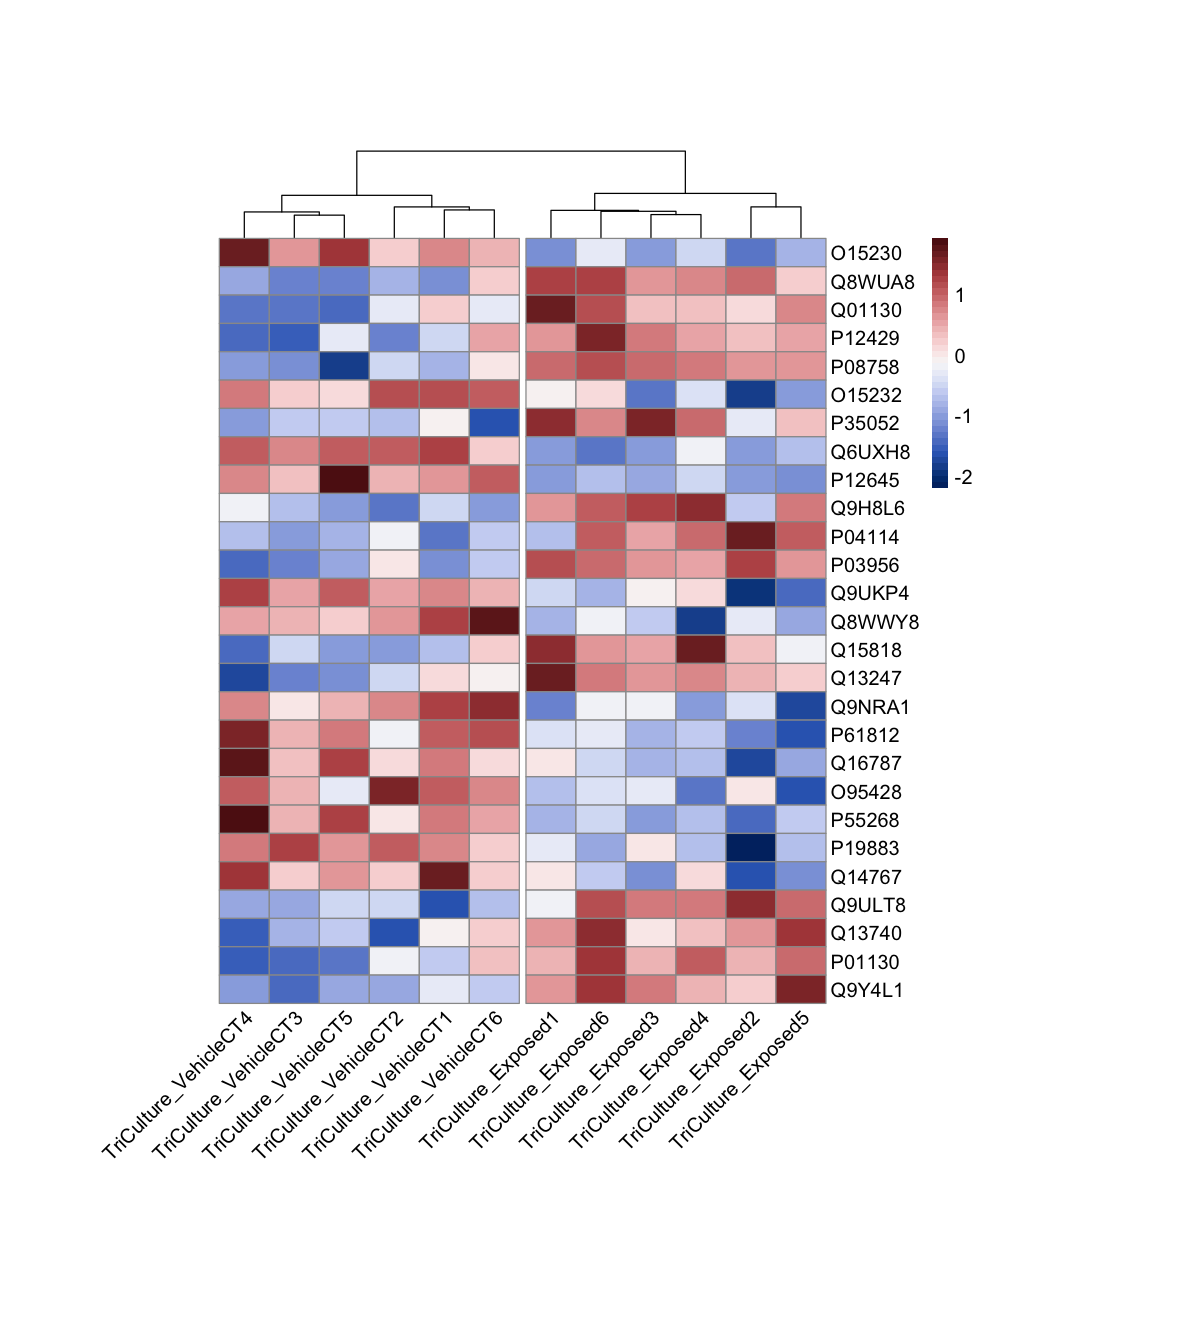

In [6]:
options(repr.plot.width=10, repr.plot.height=11) #changing size
FigureXa = pheatmap(triculture_clustering_df, cluster_rows = FALSE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12,  
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Red 3"), 
         cutree_col = 2) # adds a break bewtween the largest clusters

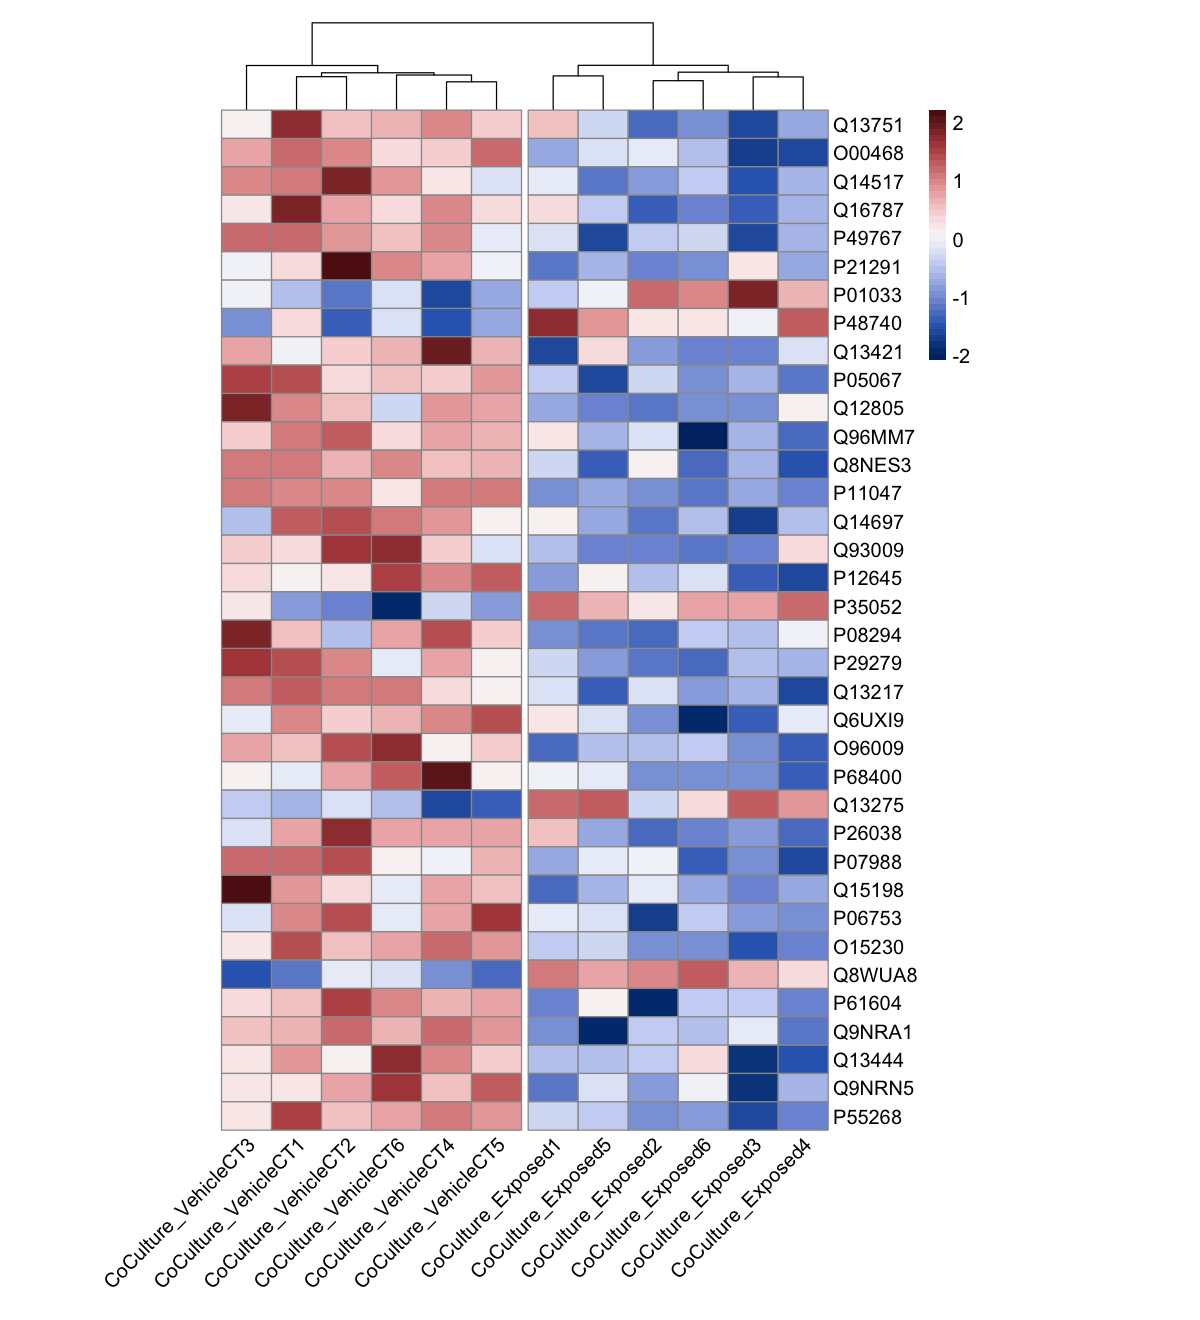

In [7]:
FigureXb = pheatmap(coculture_clustering_df, cluster_rows = FALSE, cluster_cols = TRUE, 
         angle_col = 45, fontsize = 12,  
         cellheight = 17, cellwidth = 30,
         color = hcl.colors(40, "Blue-Red 3"), 
         cutree_col = 2) # adds a break bewtween the largest clusters

TableGrob (1 x 2) "arrange": 2 grobs
         z     cells    name           grob
FigureXa 1 (1-1,1-1) arrange gtable[layout]
FigureXb 2 (1-1,2-2) arrange gtable[layout]

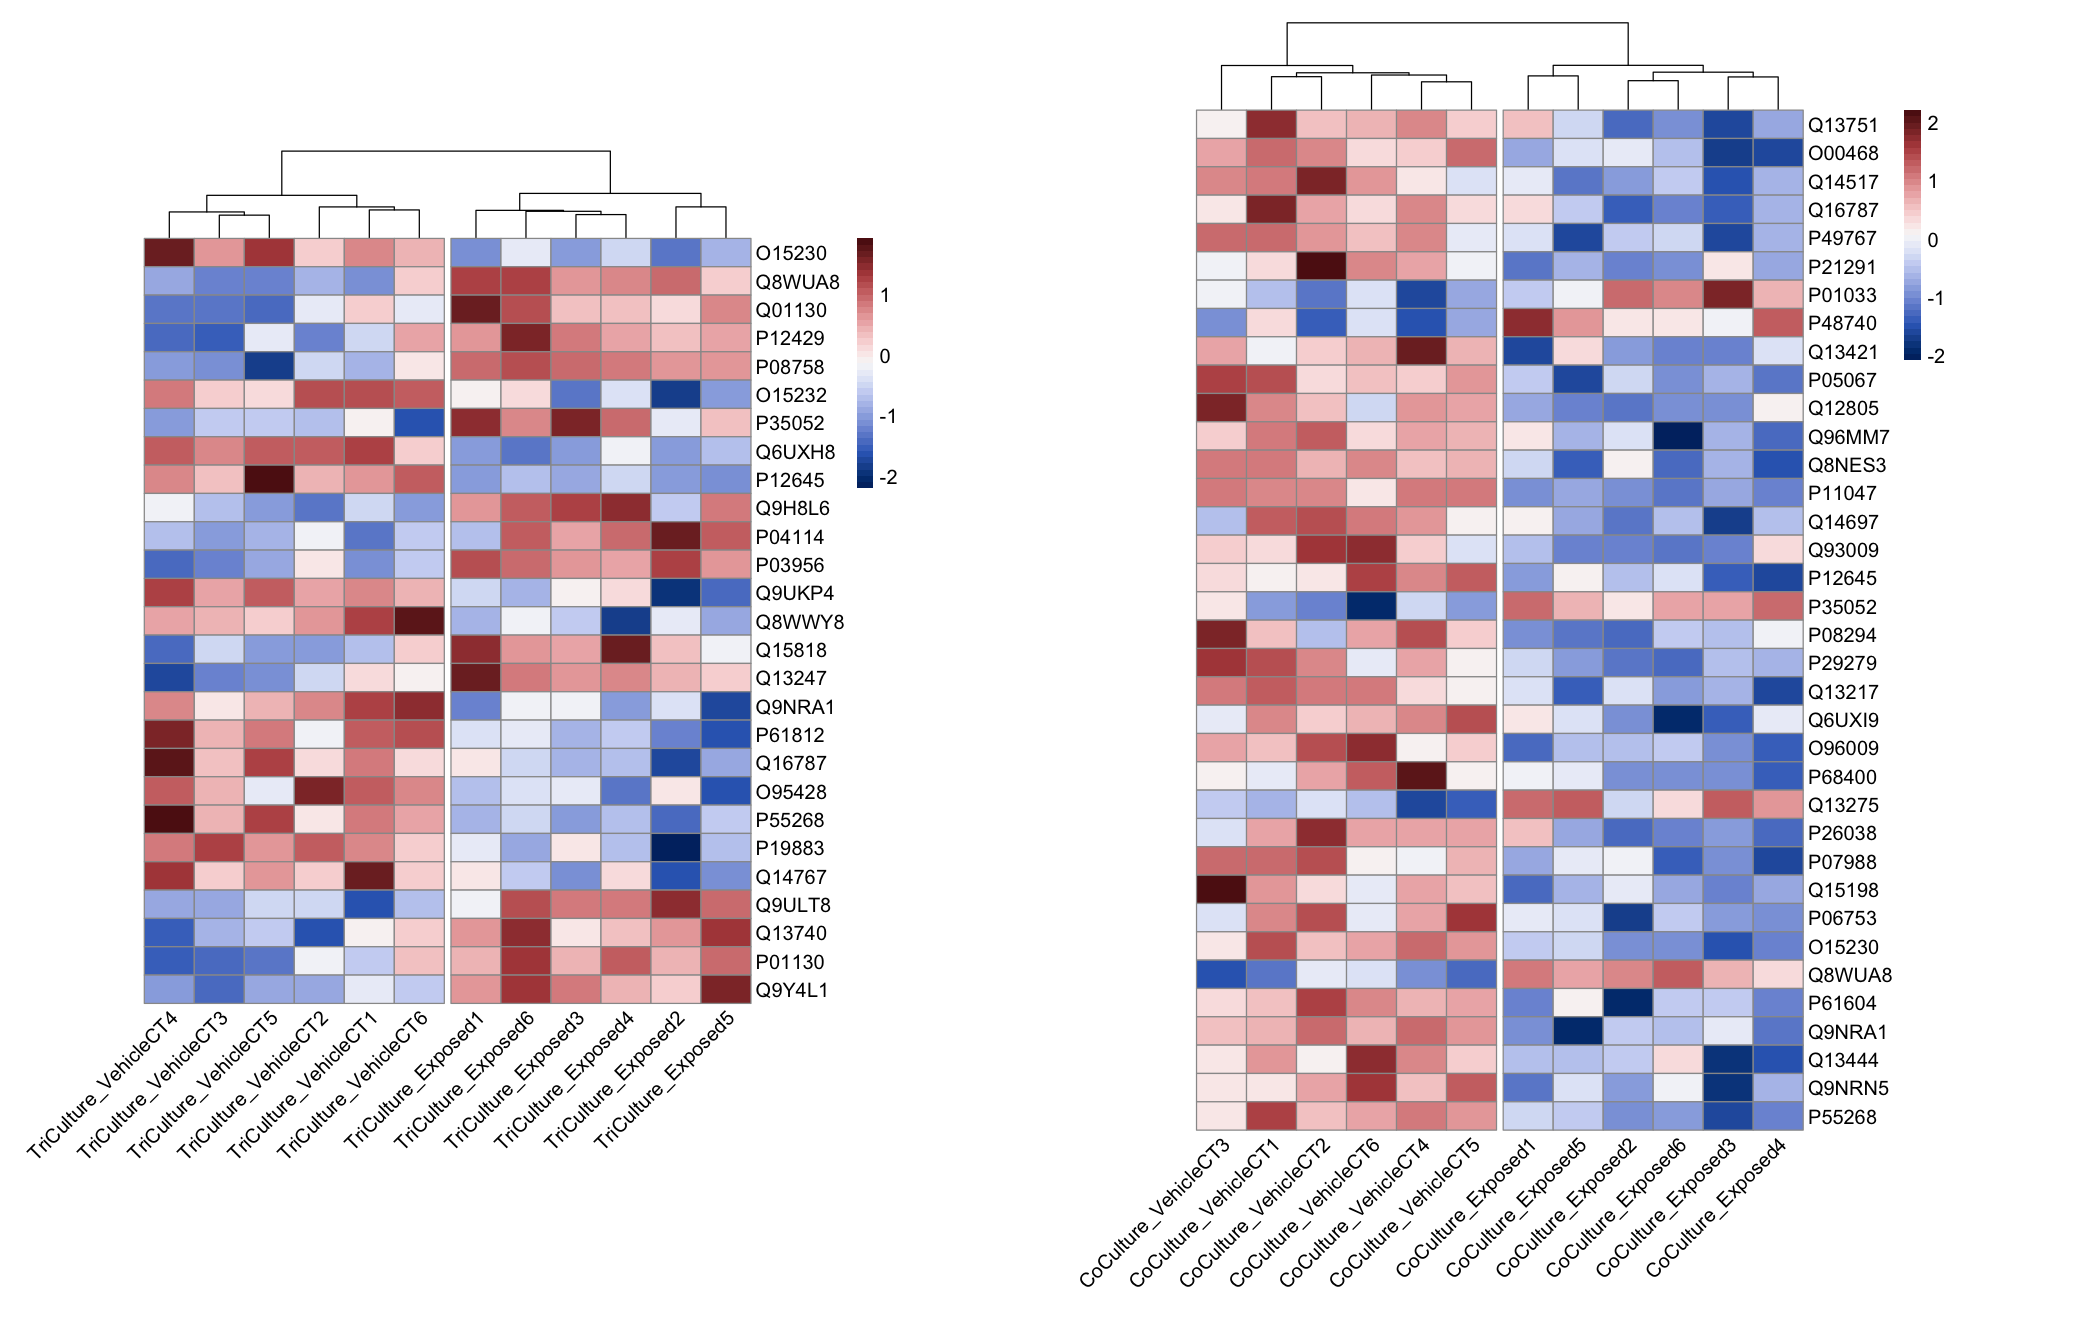

In [8]:
options(repr.plot.width=17.5, repr.plot.height=11) #changing size
# creating 1 figure
plot_list = list()
plot_list[['FigureXa']] = FigureXa[[4]]
plot_list[['FigureXb']] = FigureXb[[4]]

# creating 1 figure
FigureX = grid.arrange(grobs = plot_list, ncol = 2)
FigureX

In [9]:
# exporting figure
# ggsave(Figure6, 
#        filename = 'Figure6.pdf',
#        path = Output,
#        width = 16, height = 8)